# Create a file to explore NEO data in [Glue](http://docs.glueviz.org/en/stable/index.html)

NEO data were downloaded from the [JPL Small-Body Database](https://ssd.jpl.nasa.gov/sbdb_query.cgi), and the [NEO Earth Close Approaches archive](https://cneos.jpl.nasa.gov/ca/).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
neo = pd.read_csv('data/JPLNEO.csv')
neo.iloc[:3]

,pdes,H,G,diameter,albedo,rot_per,BV,UB,IR,e,...,i,om,w,ma,n,tp,per,q,ad,moid
0,433,11.16,0.46,16.84,0.25,5.270,0.921,0.531,NaN,0.222736,...,10.828567,304.306262,178.821360,47.239460,0.559780,2.458516e+06,643.109416,1.133339,1.782886,0.149341
1,719,15.40,NaN,NaN,NaN,5.801,NaN,NaN,NaN,0.546301,...,11.564845,183.887286,156.163669,48.317252,0.229932,2.458390e+06,1565.680891,1.197212,4.080348,0.203359
2,887,13.40,-0.12,4.20,0.31,73.970,0.832,0.436,NaN,0.569116,...,9.384537,110.428481,350.414321,193.414347,0.252901,2.459259e+06,1423.484303,1.067080,3.885896,0.086571


Text(0, 0.5, 'diameter (km)')

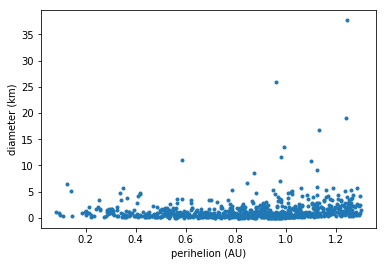

In [3]:
f,ax = plt.subplots()
ax.plot(neo['q'], neo['diameter'],'.')
ax.set_xlabel('perihelion (AU)')
ax.set_ylabel('diameter (km)')

In [4]:
neoCA = pd.read_csv('data/JPLNEOCloseApproaches.csv')
neoCA.iloc[:3]

,Object,Close-Approach (CA) Date,CA Distance Nominal (LD | au),CA Distance Minimum (LD | au),V relative (km/s),V infinity (km/s),H (mag),Estimated Diameter,Unnamed: 8
0,(2012 KZ41),2019-Jun-03 23:43 ± < 00:01,3.77 | 0.00968,3.77 | 0.00968,12.03,12.00,25.1,25 m - 57 m,bK12K41Z
1,(2019 KY),2019-Jun-04 11:38 ± < 00:01,5.49 | 0.01412,5.48 | 0.01409,6.19,6.16,26.3,14 m - 32 m,bK19K00Y
2,(2019 KS),2019-Jun-04 19:42 ± < 00:01,12.22 | 0.03140,12.18 | 0.03130,17.62,17.61,24.7,31 m - 69 m,bK19K00S


### Fix the ID, date and distance

Take only the first occurance of each close approach

In [37]:
from dateutil import parser

pdes = []
date = []
distance = []
for index, row in neoCA.iterrows():
    #ID
    x = row['Object']
    if (x[0] == '('):
        p1 = x.find(')')
        iden = x[1:p1]
    else:
        p1 = x.find(' ')
        iden = x[0:p1]
    if (iden not in pdes):
        pdes.append(iden)
        
        check = neo.loc[neo['pdes'] == pdes[-1]]
        if (len(check) == 0 or len(check) > 1):
            print(pdes[-1], len(check))

        #date
        x = row['Close-Approach (CA) Date']
        p1 = x.find('±') -1
        dt = parser.parse(x[0:p1])
        date.append(dt.year + dt.month/12. + dt.day/365.24 + dt.hour/8760. + dt.minute/(8760.*60.) + dt.second/(8760.*60.*60.))

        #distance
        x = row['CA Distance Nominal (LD | au)']
        p1 = x.find('|')+1
        distance.append(x[p1:])     


15P/Finla 0
249P/LINEA 0
73P/Schwassmann-Wachmann 0


In [38]:
#3 are missing...
neo.loc[neo['pdes'] == '15P Finla']

,pdes,H,G,diameter,albedo,rot_per,BV,UB,IR,e,...,i,om,w,ma,n,tp,per,q,ad,moid


### Merge the data

In [39]:
output = pd.DataFrame()
output['pdes'] = pdes
output['CAdate'] = date
output['CAdistance'] = distance
output['CAvelocity'] = neoCA['V relative (km/s)']

mg = neo.merge(output, on='pdes', how='outer')
print(len(output), output['pdes'].nunique(), len(neo), len(mg))

3501 3501 20412 20415


In [40]:
mg.iloc[:3]

,pdes,H,G,diameter,albedo,rot_per,BV,UB,IR,e,...,ma,n,tp,per,q,ad,moid,CAdate,CAdistance,CAvelocity
0,433,11.16,0.46,16.84,0.25,5.270,0.921,0.531,NaN,0.222736,...,47.239460,0.559780,2.458516e+06,643.109416,1.133339,1.782886,0.149341,NaN,NaN,NaN
1,719,15.40,NaN,NaN,NaN,5.801,NaN,NaN,NaN,0.546301,...,48.317252,0.229932,2.458390e+06,1565.680891,1.197212,4.080348,0.203359,NaN,NaN,NaN
2,887,13.40,-0.12,4.20,0.31,73.970,0.832,0.436,NaN,0.569116,...,193.414347,0.252901,2.459259e+06,1423.484303,1.067080,3.885896,0.086571,NaN,NaN,NaN


### Write to the new file

In [41]:
mg.to_csv('data/JPLNEOCloseApproaches_merge.csv', index=False)